## Classification of Patient Heart Disease with Keras - MLP
Using neural network model to learn a mapping between patient profile attributes as input features and if has heart disease as an output feature that is a label.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
seed = 8
np.random.seed(seed)

In [3]:
! pip install kaggle

In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d ronitf/heart-disease-uci

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 3.03MB/s]


In [10]:
!unzip "/content/heart-disease-uci.zip" -d "/content/heart-disease dataset"

Archive:  /content/heart-disease-uci.zip
  inflating: /content/heart-disease dataset/heart.csv  


In [11]:
data = pd.read_csv("/content/heart-disease dataset/heart.csv", header=0)
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [12]:
data.tail(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
293,67,1,2,152,212,0,0,150,0,0.8,1,0,3,0
294,44,1,0,120,169,0,1,144,1,2.8,0,0,1,0
295,63,1,0,140,187,0,0,144,1,4.0,2,2,3,0
296,63,0,0,124,197,0,1,136,1,0.0,1,0,2,0
297,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


The dataset contains the following features:

age(in years)

sex: (1 = male; 0 = female)

cp: chest pain type

trestbps: resting blood pressure (in mm Hg on admission to the hospital)

chol: serum cholestoral in mg/dl

fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

restecg: resting electrocardiographic results

thalach: maximum heart rate achieved

exang: exercise induced angina (1 = yes; 0 = no)

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by flourosopy

thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

target: 1 or 0 ( with 1 = Yes has disease, and 0= No disease


In [13]:
print('Number of rows in the dataset: ',data.shape[0])
print('Number of columns in the dataset: ',data.shape[1])

Number of rows in the dataset:  303
Number of columns in the dataset:  14


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [15]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Observation: above result show  chols column std is very high at 51%., follow by trestbps with 17.5%.  therefore, we need do some scaling / normalization of the data before training the model.

In [16]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

1. Observation: no empty values found which is good.

> **What are features data looks like?**

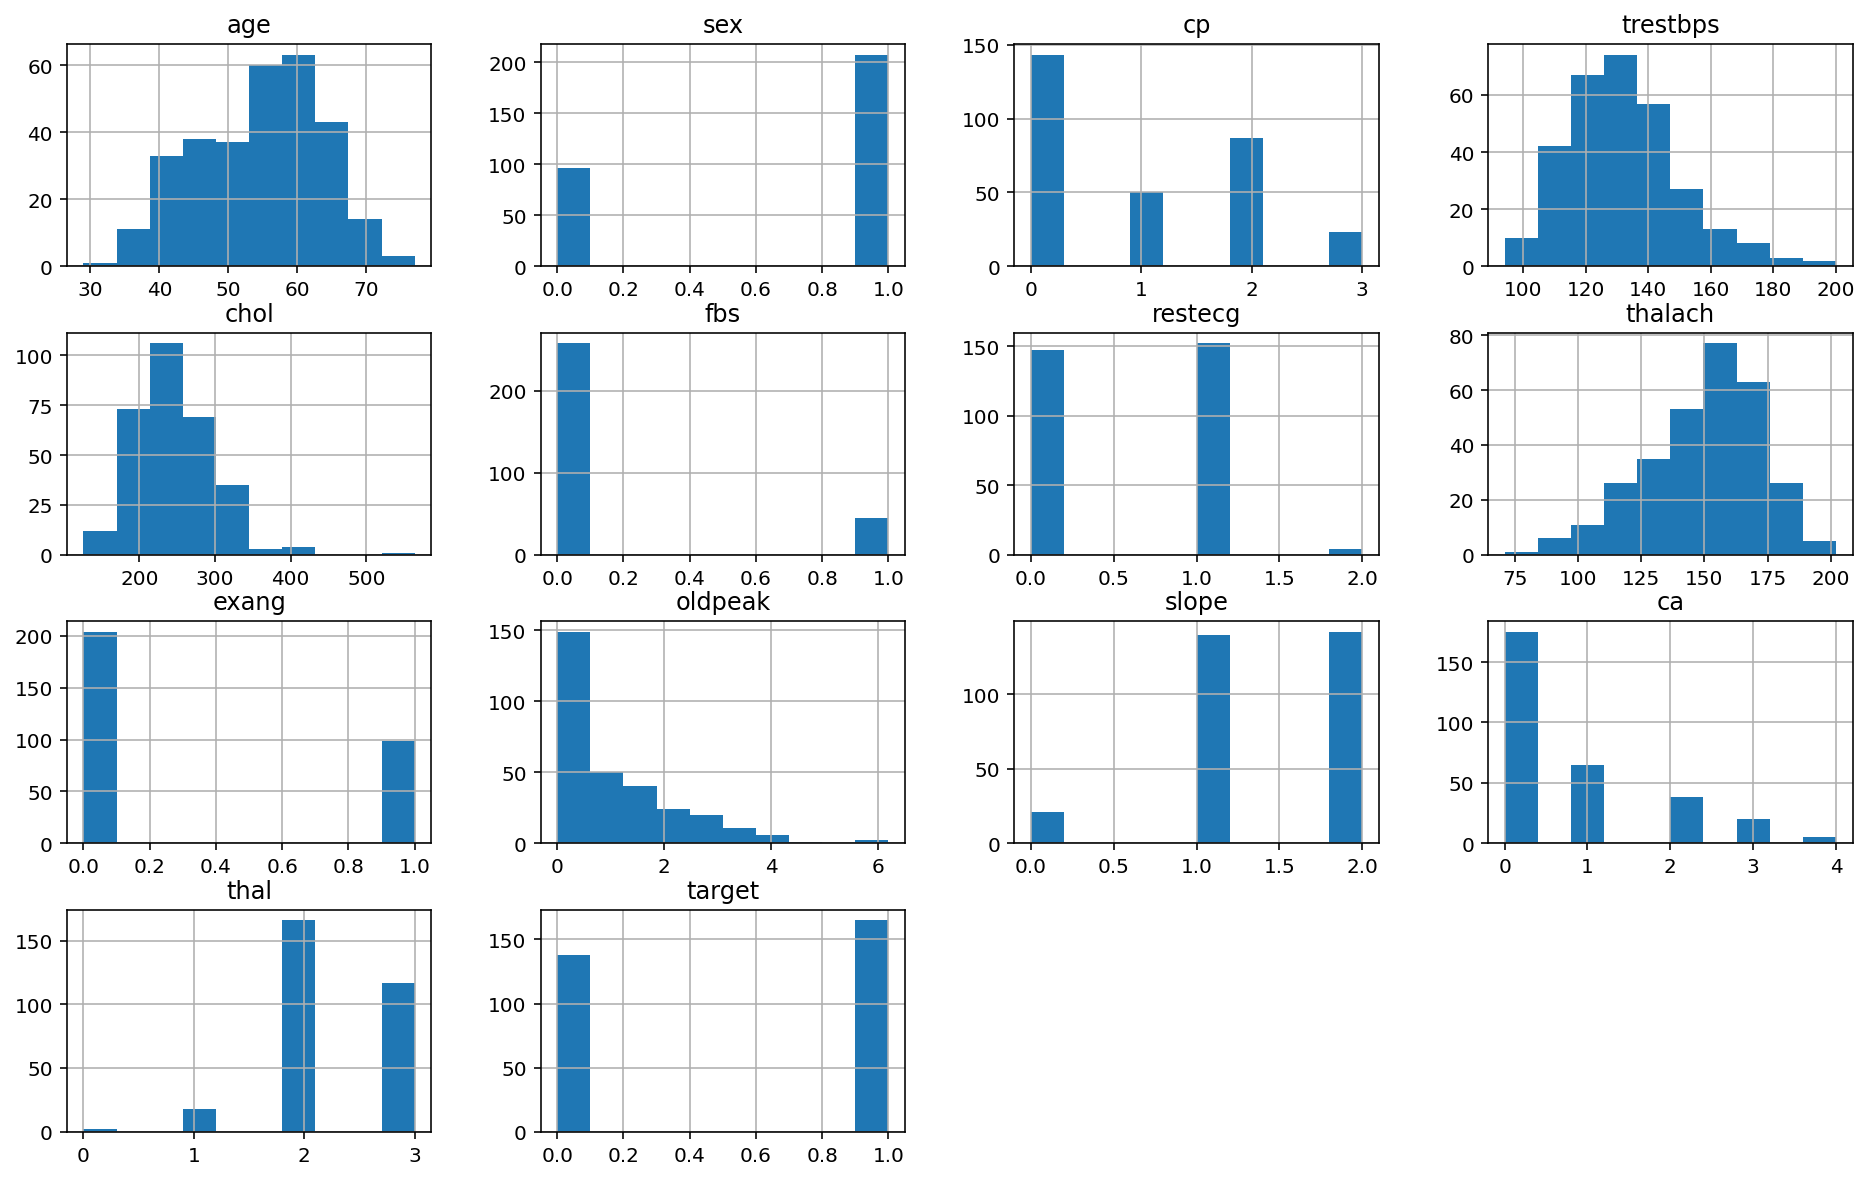

In [17]:
hist = data.hist(bins=10, figsize=(16,10))

**What is the age distribution on this dataset?**

Age max: 77  min: 29


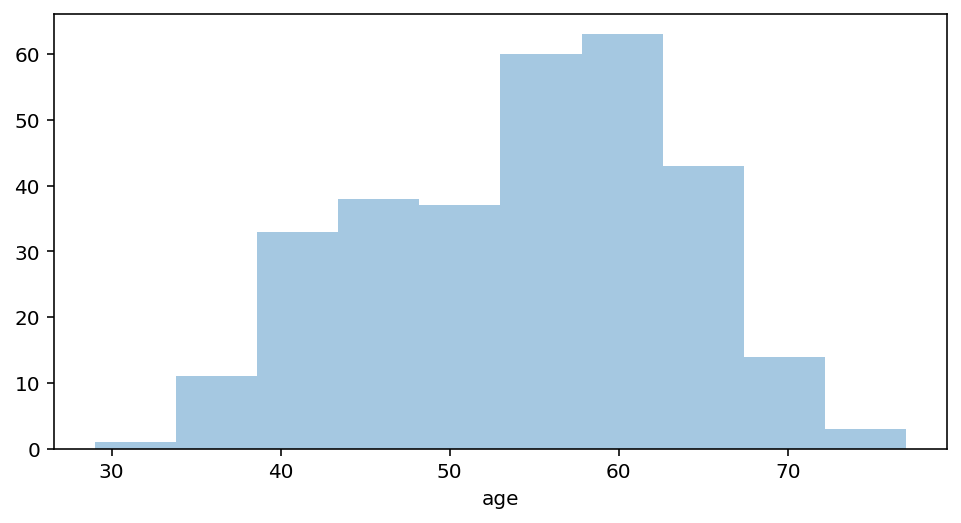

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.distplot(data['age'],kde=False,bins=10)
print ("Age max:", data['age'].max(), " min:", data['age'].min())

**How many people have chest pain and high blood sugar?**

([<matplotlib.patches.Wedge at 0x7f90c7ac5e90>,
 [Text(1.0472941106630544, -0.5858114421641848, 'fasting blood sugar < 120 mg/dl'),
  Text(-0.9600196014411332, 0.5369938219838362, 'fasting blood sugar > 120 mg/dl')],
 [Text(0.6109215645534485, -0.34172334126244114, '83.8%'),
  Text(-0.5236470553315271, 0.29290572108209245, '16.2%')])

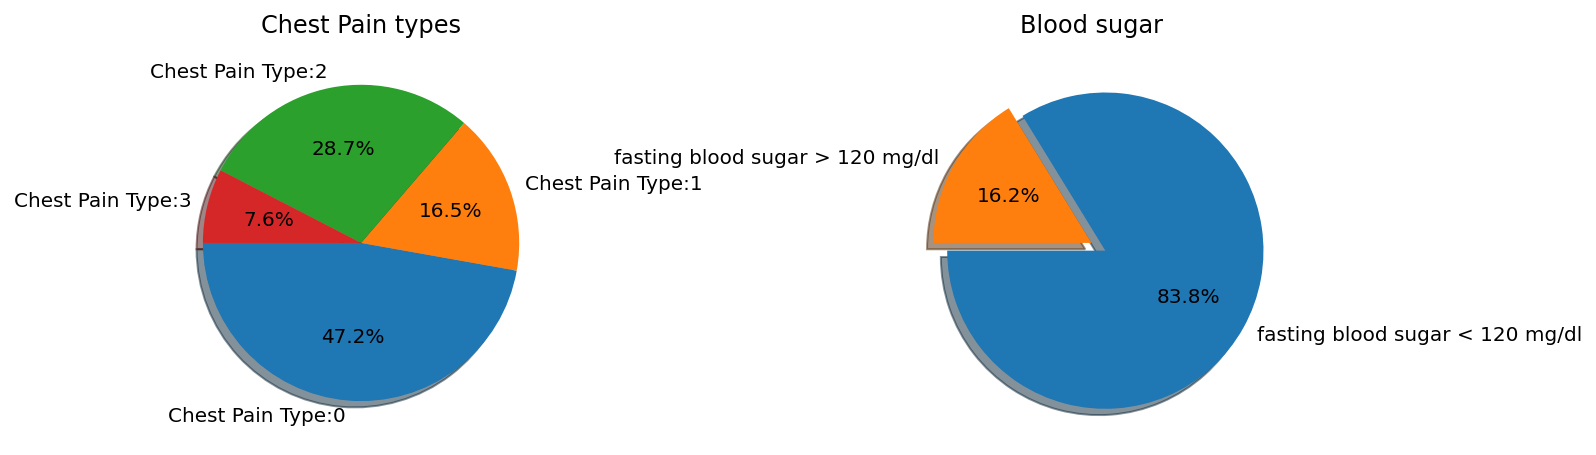

In [19]:
plt.figure(figsize=(12,8))

# Chest Pain
plt.subplot(221)
plt.title("Chest Pain types")
labels = 'Chest Pain Type:0','Chest Pain Type:1','Chest Pain Type:2','Chest Pain Type:3'
sizes = [len(data[data['cp'] == 0]),len(data[data['cp'] == 1]),
         len(data[data['cp'] == 2]),len(data[data['cp'] == 3])]
plt.pie(sizes, explode=(0, 0,0,0), labels=labels,autopct='%1.1f%%', shadow=True, startangle=180)

# blood sugar
plt.subplot(222)    
plt.title("Blood sugar")
labels = 'fasting blood sugar < 120 mg/dl','fasting blood sugar > 120 mg/dl'
sizes = [len(data[data['fbs'] == 0]),len(data[data['cp'] == 1])]
plt.pie(sizes, explode=(0.1, 0), labels=labels, autopct='%1.1f%%', shadow=True, startangle=180)

**Is there any correlation between features?**
Understanding correction among features which will be useful for model feature selection

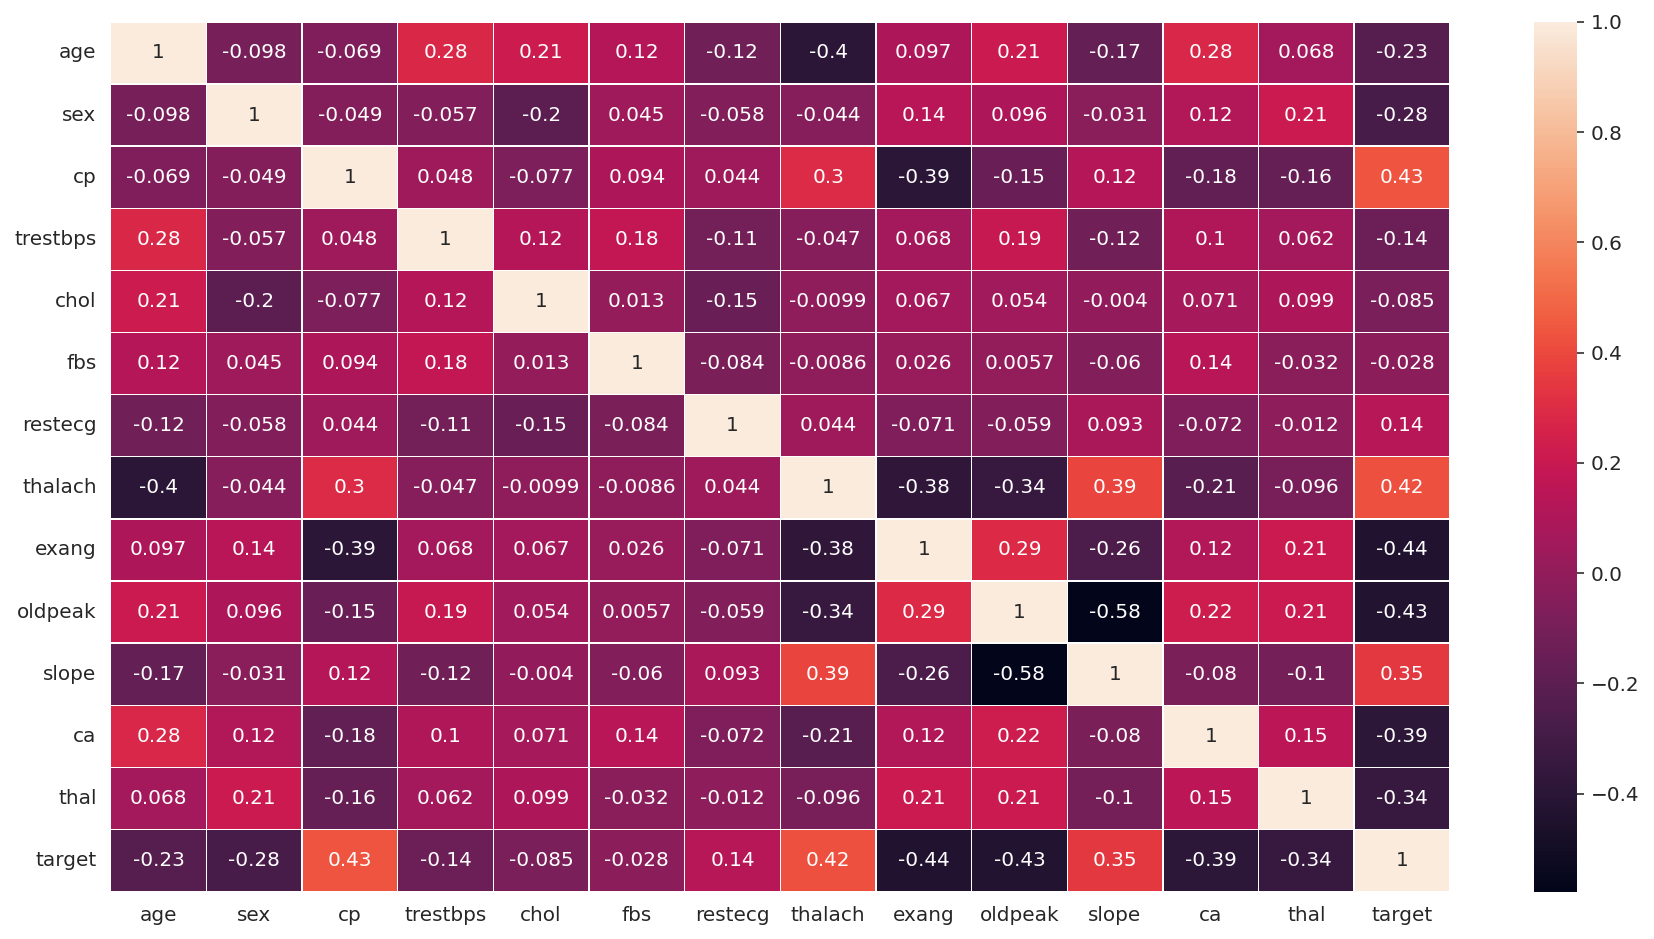

In [20]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True, linewidths=.2)
plt.show()

> Observation: result suggest not tight correction between features 

**Target Label**

Text(0.5, 1.0, 'Count of each Target Class')

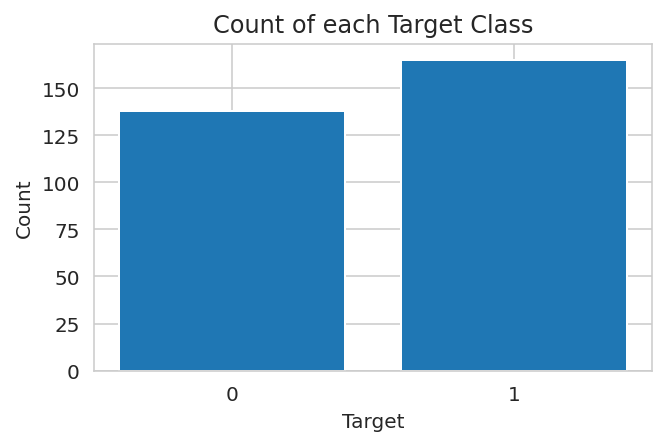

In [21]:
rcParams['figure.figsize'] = 5,3
plt.bar(data['target'].unique(), data['target'].value_counts())
plt.xticks([0, 1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Count of each Target Class')

**Which age has high risk of heat disase?**

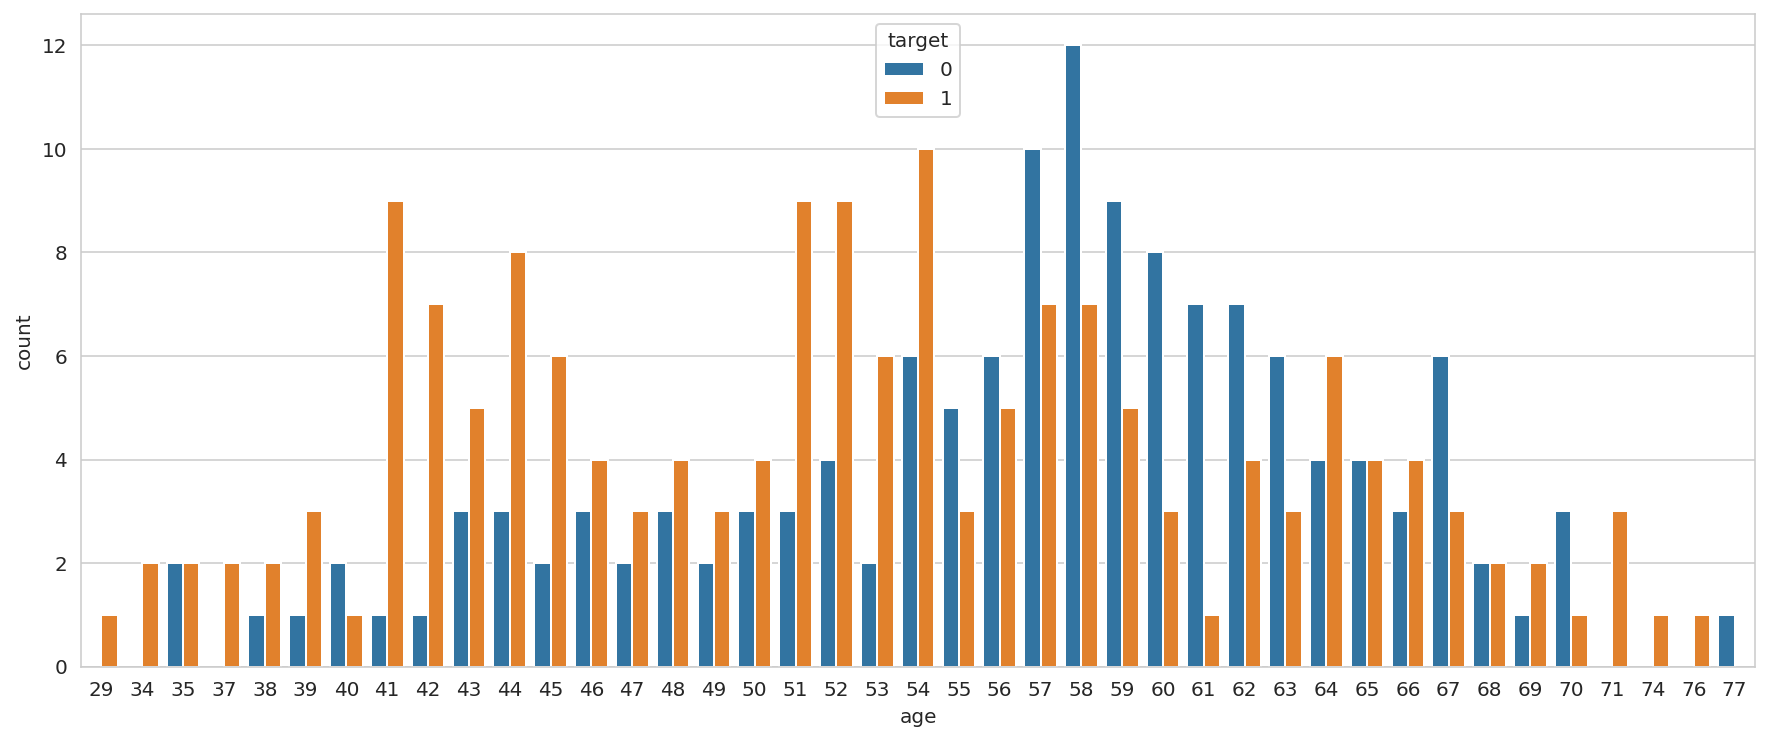

In [22]:
plt.figure(figsize=(15,6))
sns.countplot(x='age',data = data, hue = 'target')
plt.show()

Observation:people at 41-15, 51-59 amount highest one with heart disease.

In [24]:
data.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1


In [ ]:
!pip install pywedge

In [26]:
import pywedge as pw
x = pw.Pywedge_Charts(data, c=None, y="target")
charts = x.make_charts()

HTML(value='<h2>Pywedge Make_Charts </h2>')

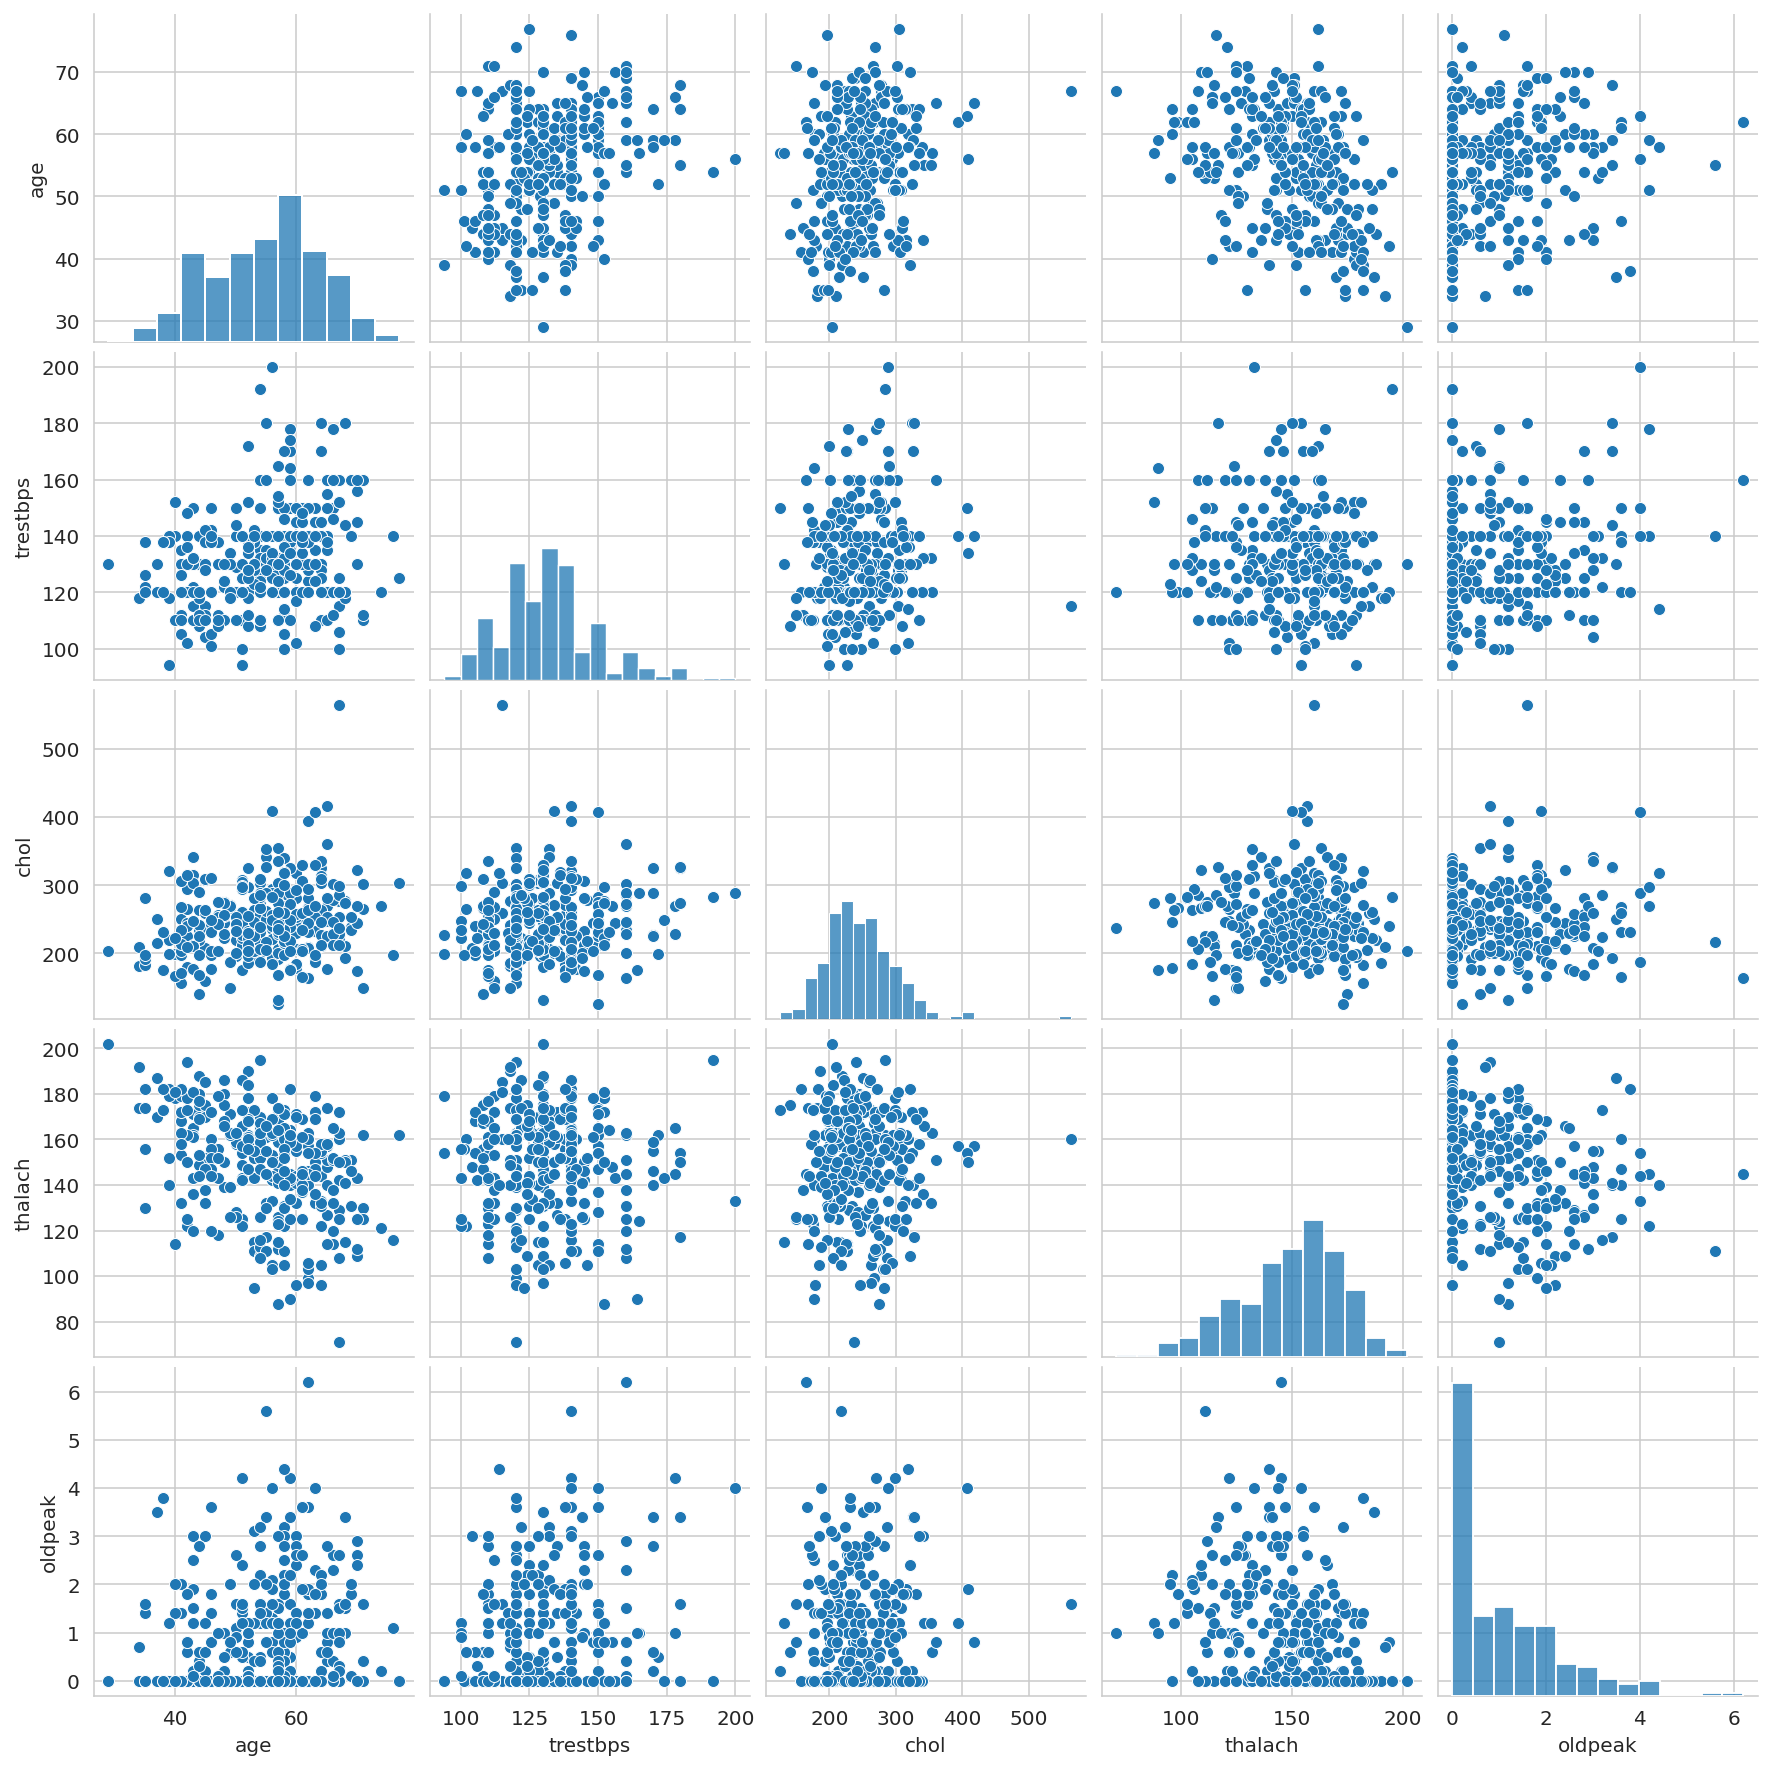

In [30]:
subData = data[['age','trestbps','chol','thalach','oldpeak']]
sns.pairplot(subData)

Text(26.426458333333343, 0.5, 'ST depression')

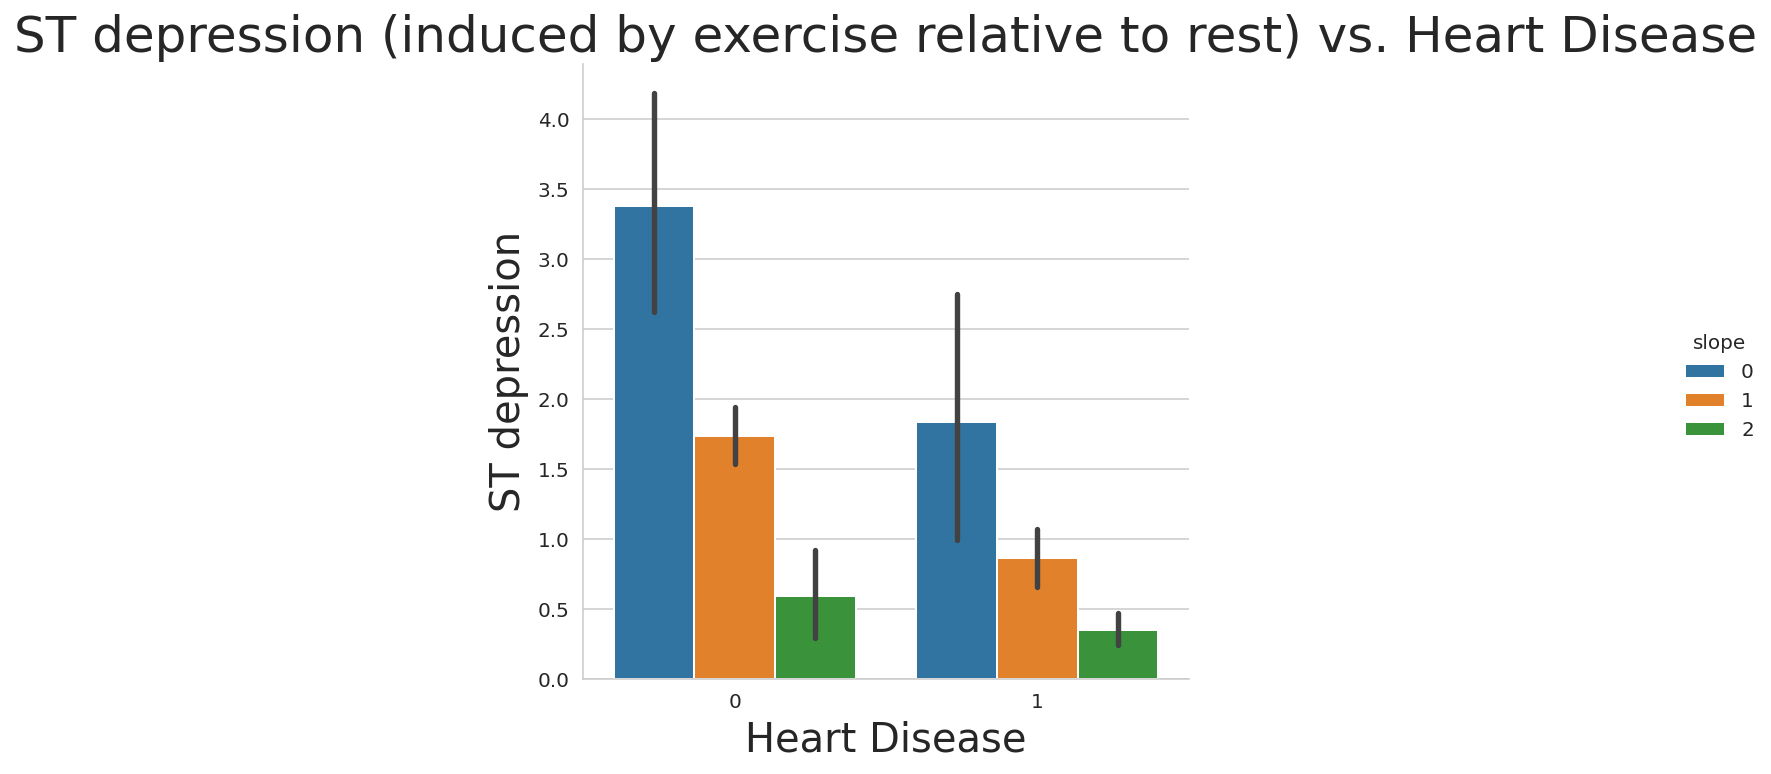

In [31]:
sns.catplot(x="target", y="oldpeak", hue="slope", kind="bar", data=data);

plt.title('ST depression (induced by exercise relative to rest) vs. Heart Disease',size=25)
plt.xlabel('Heart Disease',size=20)
plt.ylabel('ST depression',size=20)

Text(0, 0.5, 'Thalach Level')

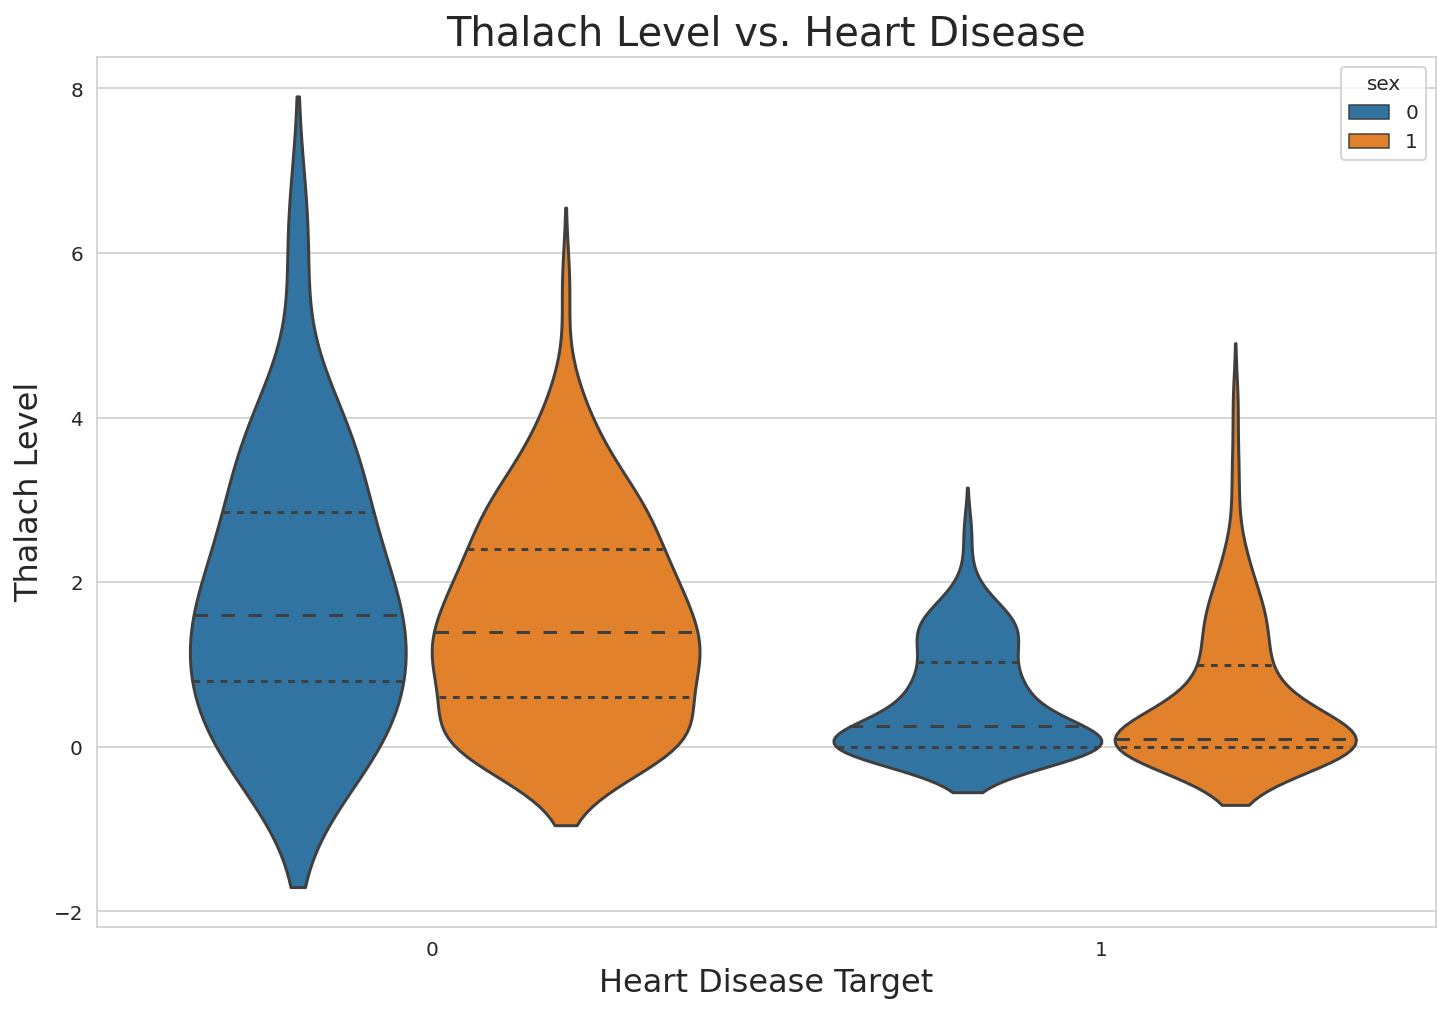

In [32]:
plt.figure(figsize=(12,8))
sns.violinplot(x= 'target', y= 'oldpeak',hue="sex", inner='quartile',data= data )
plt.title("Thalach Level vs. Heart Disease",fontsize=20)
plt.xlabel("Heart Disease Target", fontsize=16)
plt.ylabel("Thalach Level", fontsize=16)

Text(0, 0.5, 'ST depression induced by exercise relative to rest')

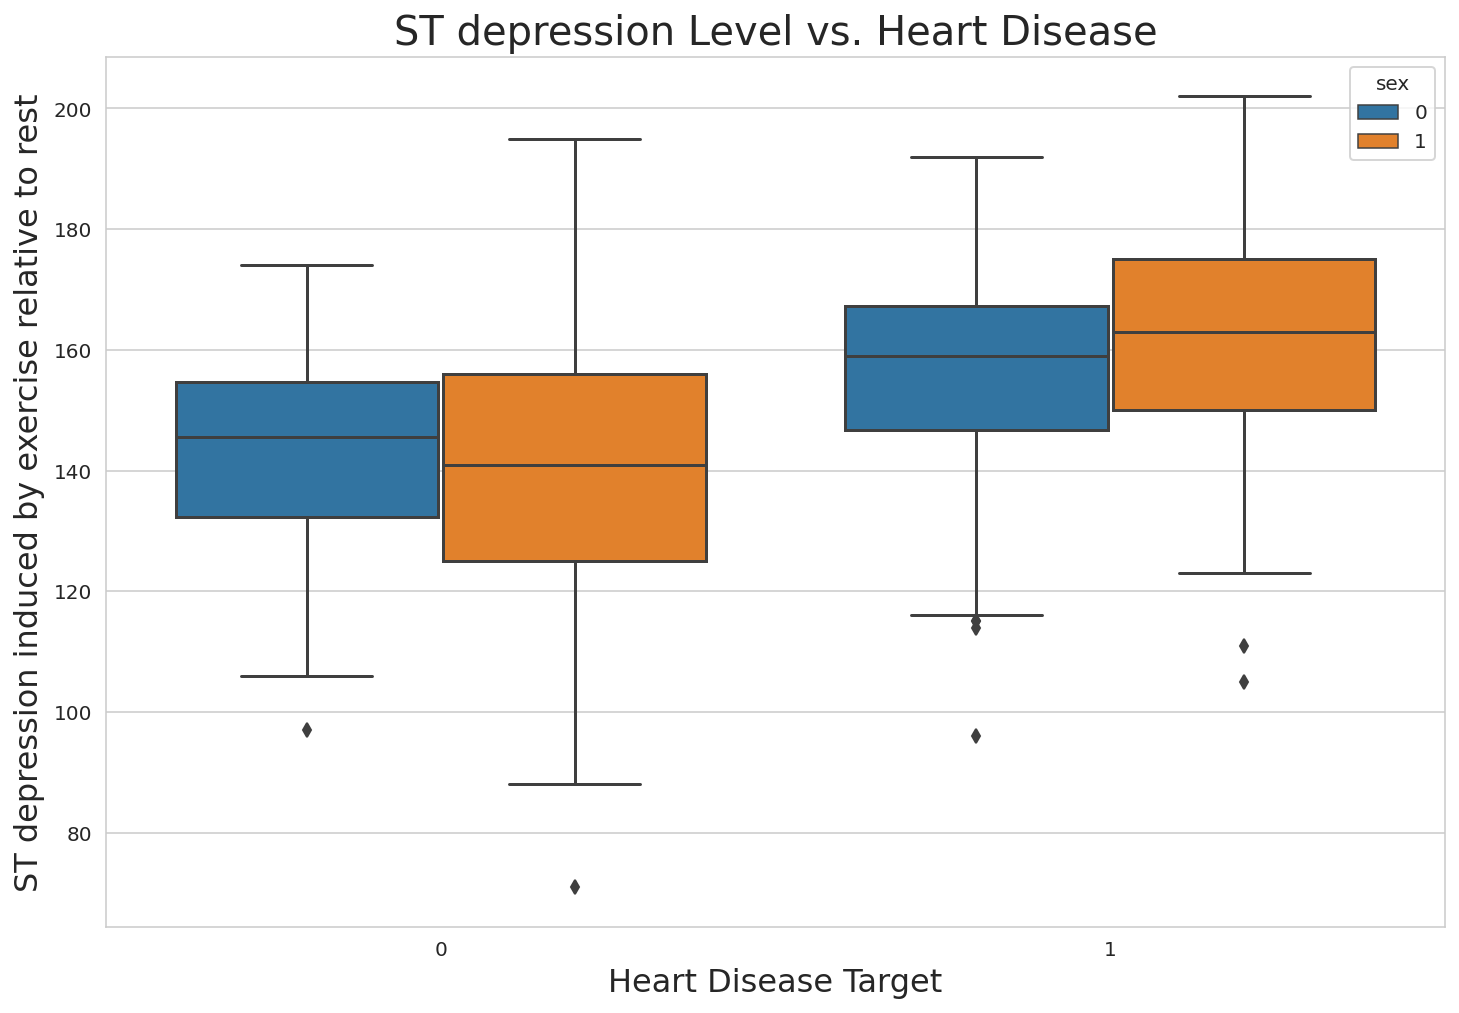

In [33]:
plt.figure(figsize=(12,8))
sns.boxplot(x= 'target', y= 'thalach',hue="sex", data=data )
plt.title("ST depression Level vs. Heart Disease", fontsize=20)
plt.xlabel("Heart Disease Target",fontsize=16)
plt.ylabel("ST depression induced by exercise relative to rest", fontsize=16)

**Prepare data for training**

In [27]:
X= data.drop('target',axis=1)
Y=data['target']
print (X.shape, Y.shape, data.columns)

(303, 13) (303,) Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [28]:
# split data into train, test
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=39, shuffle=True)


# normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

print (X_train.shape, y_train.shape)
print (X_train.shape, y_test.shape)
print (data.columns)

(212, 13) (212,)
(212, 13) (91,)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


## **Machine Learning Classification Algorithms**

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(random_state=1) # get instance of model
model1.fit(X_train, y_train) # Train/Fit model 

y_pred1 = model1.predict(X_test) # get y predictions
print(classification_report(y_test, y_pred1)) # output accuracy

accuracy_score(y_test, y_pred1)

              precision    recall  f1-score   support

           0       0.85      0.76      0.80        37
           1       0.84      0.91      0.88        54

    accuracy                           0.85        91
   macro avg       0.85      0.83      0.84        91
weighted avg       0.85      0.85      0.84        91



0.8461538461538461

In [37]:
from sklearn.metrics import classification_report 
from sklearn.neighbors import KNeighborsClassifier

model2 = KNeighborsClassifier() # get instance of model
model2.fit(X_train, y_train) # Train/Fit model 

y_pred2 = model2.predict(X_test) # get y predictions
print(classification_report(y_test, y_pred2)) # output accuracy

accuracy_score(y_test, y_pred2)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75        37
           1       0.83      0.81      0.82        54

    accuracy                           0.79        91
   macro avg       0.78      0.79      0.78        91
weighted avg       0.79      0.79      0.79        91



0.7912087912087912

In [38]:
from sklearn.metrics import classification_report 
from sklearn.svm import SVC

model3 = SVC(random_state=1) # get instance of model
model3.fit(X_train, y_train) # Train/Fit model 

y_pred3 = model3.predict(X_test) # get y predictions
print(classification_report(y_test, y_pred3)) # output accuracy

accuracy_score(y_test, y_pred3)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        37
           1       0.84      0.87      0.85        54

    accuracy                           0.82        91
   macro avg       0.82      0.81      0.82        91
weighted avg       0.82      0.82      0.82        91



0.8241758241758241

In [39]:
from sklearn.metrics import classification_report 
from sklearn.naive_bayes import GaussianNB

model4 = GaussianNB() # get instance of model
model4.fit(X_train, y_train) # Train/Fit model 

y_pred4 = model4.predict(X_test) # get y predictions
print(classification_report(y_test, y_pred4)) # output accuracy

accuracy_score(y_test, y_pred4)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        37
           1       0.85      0.87      0.86        54

    accuracy                           0.84        91
   macro avg       0.83      0.83      0.83        91
weighted avg       0.83      0.84      0.83        91



0.8351648351648352

In [40]:
from sklearn.metrics import classification_report 
from sklearn.tree import DecisionTreeClassifier

model5 = DecisionTreeClassifier(random_state=1) # get instance of model
model5.fit(X_train, y_train) # Train/Fit model 

y_pred5 = model5.predict(X_test) # get y predictions
print(classification_report(y_test, y_pred5)) # output accuracy

accuracy_score(y_test, y_pred5)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        37
           1       0.81      0.80      0.80        54

    accuracy                           0.77        91
   macro avg       0.76      0.76      0.76        91
weighted avg       0.77      0.77      0.77        91



0.7692307692307693

In [41]:
from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier

model6 = RandomForestClassifier(random_state=1)# get instance of model
model6.fit(X_train, y_train) # Train/Fit model 

y_pred6 = model6.predict(X_test) # get y predictions
print(classification_report(y_test, y_pred6)) # output accuracy

accuracy_score(y_test, y_pred6)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        37
           1       0.85      0.87      0.86        54

    accuracy                           0.84        91
   macro avg       0.83      0.83      0.83        91
weighted avg       0.83      0.84      0.83        91



0.8351648351648352

In [42]:
from xgboost import XGBClassifier

model7 = XGBClassifier(random_state=1)
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)
print(classification_report(y_test, y_pred7))

accuracy_score(y_test, y_pred7)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.90      0.87      0.89        54

    accuracy                           0.87        91
   macro avg       0.86      0.87      0.86        91
weighted avg       0.87      0.87      0.87        91



0.8681318681318682

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred6)
print(cm)

[[29  8]
 [ 7 47]]


In [44]:
# get importance
importance = model6.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.09177
Feature: 1, Score: 0.03109
Feature: 2, Score: 0.10586
Feature: 3, Score: 0.08953
Feature: 4, Score: 0.07738
Feature: 5, Score: 0.01279
Feature: 6, Score: 0.01920
Feature: 7, Score: 0.12262
Feature: 8, Score: 0.06781
Feature: 9, Score: 0.09843
Feature: 10, Score: 0.07323
Feature: 11, Score: 0.07899
Feature: 12, Score: 0.13131


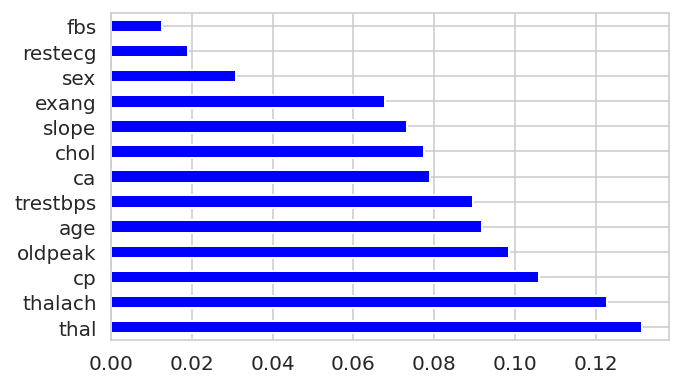

In [45]:

index= data.columns[:-1]
importance = pd.Series(model6.feature_importances_, index=index)
importance.nlargest(13).plot(kind='barh', colormap='winter')

In [46]:
y_pred = model6.predict(X_test)
print(y_pred[:10])

[1 1 0 1 0 0 1 1 0 0]


## **Model Training Using Keras**

**Which features are the most important in relation to heart disease?**  let's find out by using XGBoost classifier

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
best_xgc_score=0
model = XGBClassifier(max_depth=7)
model.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=False)
predictions = model.predict(X_test)
best_xgc_score = accuracy_score(y_test,predictions)
print ("XGBClassifier accuracy: ", best_xgc_score)

XGBClassifier accuracy:  0.8681318681318682


In [48]:
predictions

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1])

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
[ 4.9345617  5.085717  13.123428   4.593315   2.887094   4.6395245
  2.283532   4.3266835  6.4648867  7.3496895  7.3311253  8.716037
 28.264406 ]
[0 1]


Text(0.5, 1.0, 'Feature importances')

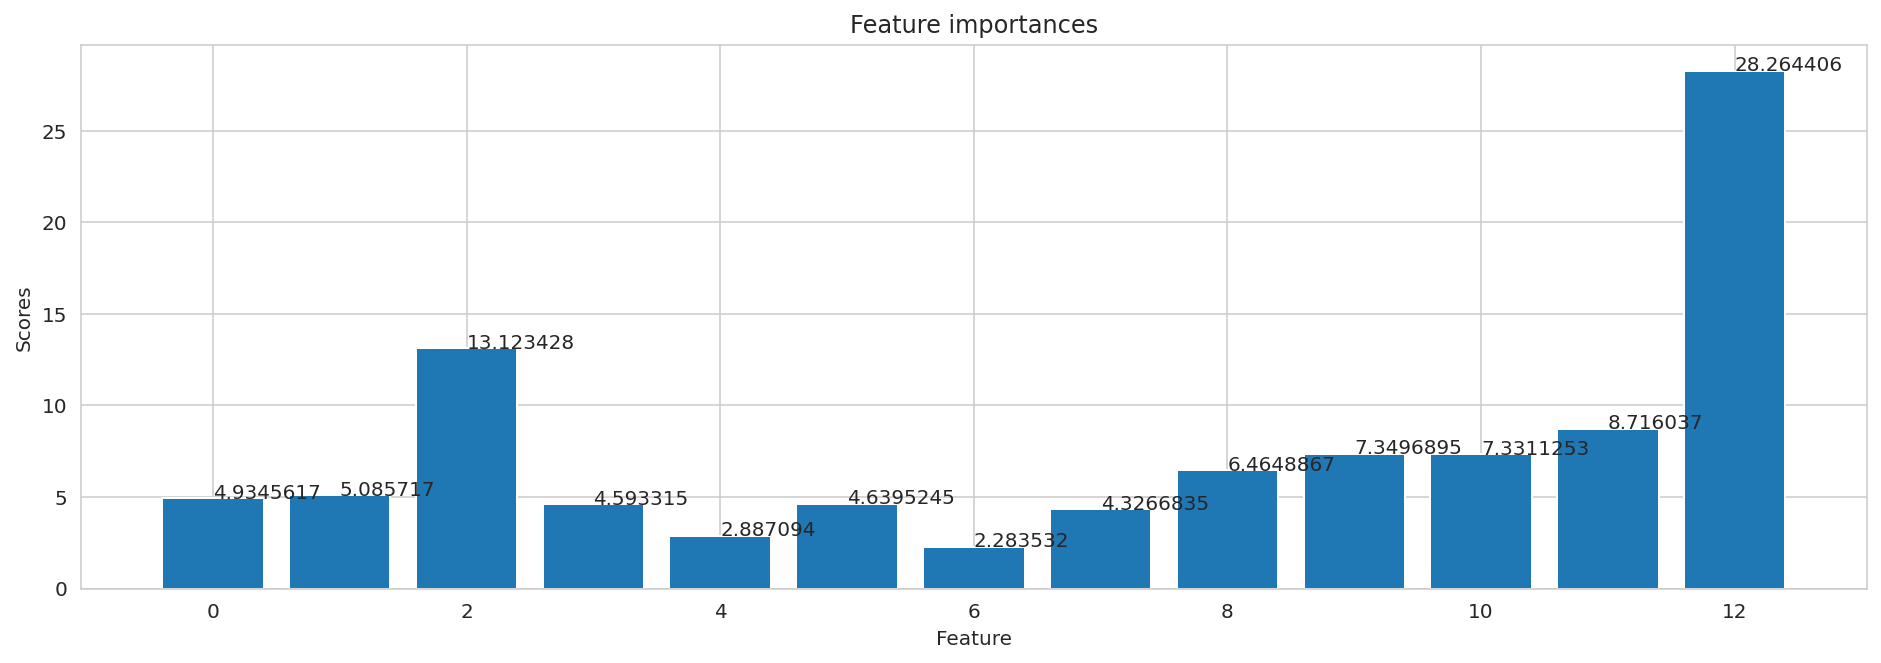

In [49]:
print (X.columns) 
print (model.feature_importances_*100)
print (model.classes_)  # output
# visualize it
plt.figure(figsize=(16,5))
rf_scores=model.feature_importances_*100
plt.bar([i for i in range(len(X.columns))], rf_scores, width = 0.8)
for i in range(len(X.columns)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xlabel('Feature')
plt.ylabel('Scores')
plt.title('Feature importances')

**Build Model**

In [50]:
# Define some useful callbacks
#Reduce learning rate when a metric has stopped improving.

reducelrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Stop training when a monitored quantity has stopped improving. 
# By default, mode is set to ‘auto‘ and knows that you want to minimize loss or maximize accuracy.

early_stopping_monitor=EarlyStopping(monitor='val_loss',verbose=1, patience=30, baseline=0.4, )

# Save the model after every epoch.
best_trained_model_file= 'best_trained_model.h5'
checkpoint = ModelCheckpoint(best_trained_model_file, verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  

#place callbacks want to enable on this list
callbacks=[checkpoint, reducelrp]

**Define network**

In [51]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(Dense(12, input_dim=13, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="Adamax", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                168       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


**Train model**

trainning model....  please wait!


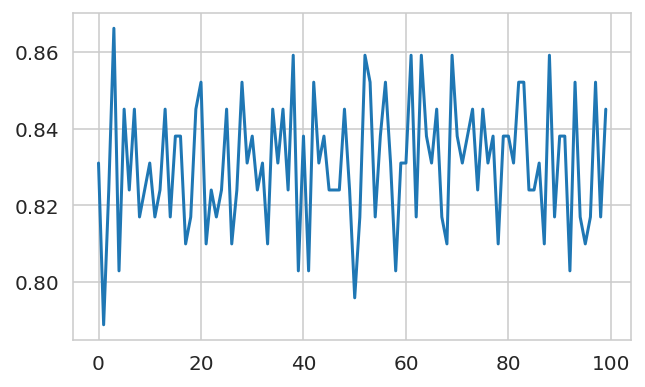

model training - finished
CPU times: user 7.54 s, sys: 412 ms, total: 7.95 s
Wall time: 10.6 s


In [53]:
%%time
# fit the model
print ("trainning model....  please wait!")
history=model.fit(X_train, y_train, validation_split=0.33, epochs=100, batch_size=6, callbacks=callbacks,verbose=0)
plt.plot(history.history['accuracy'])
plt.show()
print ("model training - finished")

**Evaluate model**

In [54]:
print("Evaluate model against trained data")
score = model.evaluate(X_train, y_train, verbose=0)
print("score %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

print("Evaluate model against new data")
score = model.evaluate(X_test, y_test, verbose=0)
print("score %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Evaluate model against trained data
score accuracy: 85.85%
Evaluate model against new data
score accuracy: 84.62%


**Model performance validation**
How good does the model perform against unseen data?

In [57]:
%%time
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
print ("running model performance validation... please wait!")
for train, test in kfold.split(X, Y):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=13, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="Adamax", metrics=['accuracy'])
    # Fit the model
    history=model.fit(X_train, y_train, epochs=100, batch_size=6, verbose=0)    
    # evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print ("done.")
print ("summary report on mean and std.")
# The average and standard deviation of the model performance 
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

running model performance validation... please wait!
accuracy: 83.52%
accuracy: 81.32%
accuracy: 82.42%
accuracy: 82.42%
accuracy: 84.62%
accuracy: 82.42%
accuracy: 82.42%
accuracy: 85.71%
accuracy: 82.42%
accuracy: 81.32%
done.
summary report on mean and std.
82.86% (+/- 1.32%)
CPU times: user 1min 4s, sys: 3.89 s, total: 1min 8s
Wall time: 54.9 s


* model performace summary report on mean and std [  85.82% (+/- 0.33%) }